# Final Project

# Exploring the effects of Quantization on Deep Learning
### Authors: Philip Spencer and Paul Jojy
In this project, we will be exploring the effects of quantization on deep learning. This is an important topic in this field, as deep learning models are very large and can be inefficient to run on edge devices such as smart phones. ADD MORE LATER
    
# 0. Initialization and Configuration

In [1]:
#CV packages
import torch
from torchvision import models, datasets, transforms, utils
from torchvision.datasets import CIFAR10
#from torch import _six
#Data presentation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.ao.ns._numeric_suite_fx as ns

#Data handling
import numpy as np
import pandas as pd
import copy

#Utilities
import time
import os

In [2]:
torch.__version__

'2.0.0'

###  0.1 Configuration

In [3]:
#Any Folder/Preface for models here, you may need to change this or create the folder
modelFolderPath = "./Saved_Models/"
if not os.path.exists(modelFolderPath):
    os.mkdir(modelFolderPath)

In [4]:
#Configure notebook for the run
sns.set(rc={'figure.figsize':(5,4)})
plt.ion()

#Set cuda device
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu' #Uncomment this line if you prefer cpu
print("Device:", DEVICE)

#This may help clear issues, uncomment as needed
torch.cuda.empty_cache()

#setup torch for training
torch.backends.cudnn.benchmark= True

#Set seed for reproducable results
torch.manual_seed(0)

Device: cuda:0


In [5]:
#Define hyperparameters, and more
BATCH_SIZE = 200
EPOCHS = 6
LEARNING_RATE = 0.001
VALIDATION_RATIO = 0.85
LR_GAMMA = 0.1 #lr decay rate
LR_STEP_SIZE_DECAY = int(EPOCHS/3.0) #base this off total epochs to allow for fine tuning

# 1. Download and Preprocess Data
We will be analyzing CIFAR-10 and MNIST for this experiment. The data must be downloaded, normalized, and augmented to maximize performance.

In [6]:
def datadownload(is_inception=False):
    if is_inception:
        input_size = (299,299)
    else:
        input_size = (224,224)
    
    cifar_augmenter = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    cifar_train = CIFAR10('.',download=True, transform=cifar_augmenter)
    cifar_test = datasets.CIFAR10('.',train=False, transform=cifar_augmenter)
    
    mnist_augmenter = transforms.Compose([
        transforms.Resize(input_size),
        transforms.Grayscale(num_output_channels=3), #Convert grayscale to RGB where R=G=B. This is because the model is pretrained on an RGB dataset (Imagenet)
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    mnist_train = datasets.MNIST('.',download=True, transform=mnist_augmenter)
    mnist_test = datasets.MNIST('.',train=False, transform=mnist_augmenter)
    
    return (cifar_train,cifar_test),(mnist_train,mnist_test)
cifar,mnist = datadownload()
inception_cifar, inception_mnist = datadownload(is_inception=True)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
mnist

(Dataset MNIST
     Number of datapoints: 60000
     Root location: .
     Split: Train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                Grayscale(num_output_channels=3)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: .
     Split: Test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                Grayscale(num_output_channels=3)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ))

In [8]:
cifar

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: .
     Split: Train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: .
     Split: Test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ))

### 1.1 Prepare Dataloaders

In [9]:
numClassesMnist = len(mnist[0].classes)
classesMnist = mnist[0].classes
classesNumericMnist = [numericClass for numericClass in range(len(classesMnist))]
numClassesCifar = len(cifar[0].classes)
classesCifar = cifar[0].classes
classesNumericCifar = [numericClass for numericClass in range(len(classesCifar))]

In [10]:
print(classesCifar,classesNumericCifar)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [11]:
def prepare_mnist(mnist):
    #Prepare MNIST training data 
    mnistTrainSplit, mnistValSplit = torch.utils.data.random_split(mnist[0], [VALIDATION_RATIO, 1-VALIDATION_RATIO])
    mnist_train_loader = torch.utils.data.DataLoader(mnistTrainSplit, shuffle=True, batch_size=BATCH_SIZE)
    mnist_val_loader = torch.utils.data.DataLoader(mnistValSplit, shuffle=True, batch_size=BATCH_SIZE)

    #Prepare MNIST testing data
    mnist_test_loader = torch.utils.data.DataLoader(mnist[1], shuffle=True, batch_size=BATCH_SIZE)
    dataloaders_mnist = {'train': mnist_train_loader,
                         'val': mnist_val_loader,
                         'test': mnist_test_loader}

    return dataloaders_mnist

dataloaders_mnist = prepare_mnist(mnist)
inception_dataloaders_mnist = prepare_mnist(inception_mnist)

In [12]:
def prepare_cifar(cifar):
    #Split CIFAR training data 
    cifarTrainSplit, cifarValSplit = torch.utils.data.random_split(cifar[0], [VALIDATION_RATIO, 1-VALIDATION_RATIO])
    cifar_train_loader = torch.utils.data.DataLoader(cifarTrainSplit, shuffle=True, batch_size=BATCH_SIZE)
    cifar_val_loader = torch.utils.data.DataLoader(cifarValSplit, shuffle=True, batch_size=BATCH_SIZE)
    #Prepare MNIST testing data
    cifar_test_loader = torch.utils.data.DataLoader(cifar[1], shuffle=True, batch_size=BATCH_SIZE)
    
    dataloaders_cifar = {'train': cifar_train_loader,
                          'val': cifar_val_loader,
                          'test':cifar_test_loader}
    
    return dataloaders_cifar
dataloaders_cifar = prepare_cifar(cifar)
inception_dataloaders_cifar = prepare_cifar(inception_cifar)

In [13]:
#Display images modified from pytorch tutorial: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def imshow(inp1, inp2, title=None):
    fig, (axM, axC) = plt.subplots(1, 2, sharey=True)
    fig.suptitle(title)
    
    inp1 = inp1.numpy().transpose((1, 2, 0))
    inp1 = np.clip(inp1, 0, 1)
    inp2 = inp2.numpy().transpose((1, 2, 0))
    inp2 = np.clip(inp2, 0, 1)
    
    axM.imshow(inp1)
    axC.imshow(inp2)
    plt.pause(0.001)  # pause a bit so that plots are updated

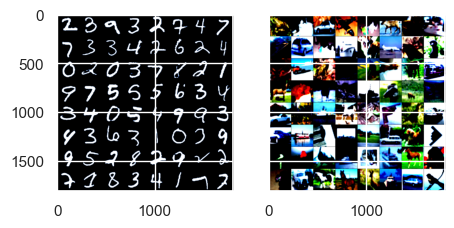

In [14]:
#Get a batch of training data from mnist and cifar
inputsM, classesM = next(iter(dataloaders_mnist['train']))
inputsC, classesC = next(iter(dataloaders_cifar['train']))
imageMax = min(64, BATCH_SIZE)

#Display sample images
imshow(utils.make_grid(inputsM[0:imageMax]), utils.make_grid(inputsC[0:imageMax]))

# 2. Create Model Architectures and Freeze layers

In [15]:
def create_mobilenet(numClasses):
    #Create base Mobilenet model
    model_temp = models.mobilenet.mobilenet_v2(pretrained=True)
    model_temp.classifier[1] = torch.nn.Linear(in_features=model_temp.classifier[1].in_features,out_features=numClasses)
    
    #Define loss functions, optimizer and scheduler
    criterion_temp = torch.nn.CrossEntropyLoss()
    optimizer_temp = torch.optim.Adam(model_temp.parameters(), lr=LEARNING_RATE)
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_temp, step_size=LR_STEP_SIZE_DECAY, gamma=LR_GAMMA)
    
    return model_temp, {'criterion':criterion_temp, 'optimizer':optimizer_temp, 'scheduler':exp_lr_scheduler}

In [16]:
def create_resnet(numClasses):
    #Create base ResNet model
    model_temp = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    num_fts_temp = model_temp.fc.in_features
    model_temp.fc = torch.nn.Linear(num_fts_temp, numClasses)
    
    #Define loss functions, optimizer and scheduler
    criterion_temp = torch.nn.CrossEntropyLoss()
    optimizer_temp = torch.optim.Adam(model_temp.parameters(), lr=LEARNING_RATE)
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_temp, step_size=LR_STEP_SIZE_DECAY, gamma=LR_GAMMA)
    
    return model_temp, {'criterion':criterion_temp, 'optimizer':optimizer_temp, 'scheduler':exp_lr_scheduler}

In [17]:
def create_inception(numClasses):
    model_temp = models.inception_v3(pretrained=True)
    # Handle the auxilary net
    num_ftrs = model_temp.AuxLogits.fc.in_features
    model_temp.AuxLogits.fc = torch.nn.Linear(num_ftrs, numClasses)
    # Handle the primary net
    num_ftrs = model_temp.fc.in_features
    model_temp.fc = torch.nn.Linear(num_ftrs,numClasses)
    input_size = 299
    
    #Define loss functions, optimizer and scheduler
    criterion_temp = torch.nn.CrossEntropyLoss()
    optimizer_temp = torch.optim.Adam(model_temp.parameters(), lr=LEARNING_RATE)
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_temp, step_size=LR_STEP_SIZE_DECAY, gamma=LR_GAMMA)
    
    return model_temp, {'criterion':criterion_temp, 'optimizer':optimizer_temp, 'scheduler':exp_lr_scheduler}

# 3. Prepare Models for Training

In [18]:
#Add early stop class, inspired by https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [19]:
#Traing method inspired by https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
#modified to fit data structure, multiple models, and keep trach of metrics accross epochs
def train_model(model, modelDict, dataloaders, num_epochs, noisy=True, epochPatience=2, minDelta=-.001, is_inception=False):
    #get model, criterion, optimizer, scheduler from dictionary 
    since = time.time()
    model = model.to(DEVICE) 
    criterion = modelDict['criterion']
    optimizer = modelDict['optimizer']
    scheduler = modelDict['scheduler']

    #Set early stopper parameters
    early_stopper = EarlyStopper(patience=epochPatience, min_delta=minDelta)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_train_acc = 0.0
    
    #Keep track of metrics from training
    metrics = pd.DataFrame(data=[],columns=['epoch','accuracy','loss','phase'])
    
    for epoch in range(num_epochs):
        if noisy:
            print(f'Epoch {epoch}/{num_epochs-1}')
            print('-' * 10)

        #Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  #Set model to training mode
            else:
                model.eval()   #Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                #Zero the parameter gradients
                optimizer.zero_grad()

                #Forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # backward + optimize for training phase
                    if is_inception and phase=='train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
            
            #Show statistics for each epoch
            epoch_loss = running_loss / len(dataloaders[phase].dataset) #dataset_sizes[phase]
            epoch_acc = (running_corrects.double()) / len(dataloaders[phase].dataset) #dataset_sizes[phase]
            
            if noisy:
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {min(epoch_acc,1.0):.4f}')
            
            #Track metrics for graphing
            metrics = pd.concat([metrics,pd.DataFrame(data=[[epoch,epoch_acc.item(),epoch_loss,phase]],columns=['epoch','accuracy','loss','phase'])], ignore_index=True)

            #Deep copy the model to keep track of the best one
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train' and epoch_acc > best_train_acc:
                best_train_acc = epoch_acc

        if noisy:
            print("")
            
        if early_stopper.early_stop(epoch_loss):
            print("Training stopped on epoch",epoch,"because the loss has not decreased by more than",minDelta,"in",epochPatience,"epochs")
            break

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc: {best_acc:4f}')
    print(f'Best Train Acc: {min(best_train_acc,1.0):4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, metrics

### 3.1 Build and Train MobileNet V2

In [20]:
#Create model for mnist dataset
mobilenet_mnist, mobilenet_mnist_dict = create_mobilenet(numClassesMnist)

#Load or train model
modelpath = modelFolderPath + 'model_mobilenet_mnist.pth'
if(os.path.exists(modelpath)):
    if DEVICE == 'cpu':
        mobilenet_mnist.load_state_dict(torch.load(modelpath, map_location=torch.device('cpu')))
    else:
        mobilenet_mnist.load_state_dict(torch.load(modelpath))
else:
    mobilenet_mnist, metrics_mobilenet_mnist = train_model(mobilenet_mnist, mobilenet_mnist_dict, dataloaders_mnist, EPOCHS)
    sns.relplot(data=metrics_mobilenet_mnist, kind="line", x="epoch", y="accuracy", hue="phase",)
    torch.save(mobilenet_mnist.state_dict(), modelpath)

C:\Users\Philip\.conda\envs\Testing\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Philip\.conda\envs\Testing\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
#Create model for cifar dataset
mobilenet_cifar, mobilenet_cifar_dict = create_mobilenet(numClassesCifar)

#Load or train model
modelpath = modelFolderPath + 'model_mobilenet_cifar.pth'
if(os.path.exists(modelpath)):
    if DEVICE == 'cpu':
        mobilenet_cifar.load_state_dict(torch.load(modelpath, map_location=torch.device('cpu'))) 
    else:
        mobilenet_cifar.load_state_dict(torch.load(modelpath)) 
else:
    mobilenet_cifar, metrics_mobilenet_cifar = train_model(mobilenet_cifar, mobilenet_cifar_dict, dataloaders_cifar, EPOCHS)
    sns.relplot(data=metrics_mobilenet_cifar, kind="line", x="epoch", y="accuracy", hue="phase",)
    torch.save(mobilenet_cifar.state_dict(), modelpath)

### 3.2 Build and Train ResNet-50

In [22]:
#Create model for mnist dataset
resNet_mnist, resNet_mnist_dict = create_resnet(numClassesMnist)
 
#Load or train model
modelpath = modelFolderPath + 'model_resnet_mnist.pth'
if(os.path.exists(modelpath)):
    if DEVICE == 'cpu':
        resNet_mnist.load_state_dict(torch.load(modelpath,map_location=torch.device('cpu')))
    else:
        resNet_mnist.load_state_dict(torch.load(modelpath))
else:
    resNet_mnist, metrics_resNet_mnist = train_model(resNet_mnist, resNet_mnist_dict, dataloaders_mnist, EPOCHS)
    sns.relplot(data=metrics_resNet_mnist, kind="line", x="epoch", y="accuracy", hue="phase",)
    torch.save(resNet_mnist.state_dict(), modelpath)

In [23]:
#Create model for cifar dataset
resNet_cifar, resNet_cifar_dict = create_resnet(numClassesCifar)
 
#Load or train model
modelpath = modelFolderPath + 'model_resnet_cifar.pth'
if(os.path.exists(modelpath)):
    if DEVICE == 'cpu':
        resNet_cifar.load_state_dict(torch.load(modelpath, map_location=torch.device('cpu')))
    else:
        resNet_cifar.load_state_dict(torch.load(modelpath))
else:
    resNet_cifar, metrics_resNet_cifar = train_model(resNet_cifar, resNet_cifar_dict, dataloaders_cifar, EPOCHS)
    sns.relplot(data=metrics_resNet_cifar, kind="line", x="epoch", y="accuracy", hue="phase",)
    torch.save(resNet_cifar.state_dict(), modelpath)

### 3.3 Build and Train Inception V3

In [24]:
#Create model for mnist dataset
inception_mnist, inception_mnist_dict = create_inception(numClassesMnist)

#Load or train model
modelpath = modelFolderPath + 'model_inception_mnist.pth'
if(os.path.exists(modelpath)):
    if DEVICE == 'cpu':
        inception_mnist.load_state_dict(torch.load(modelpath,map_location=torch.device('cpu')))
    else:
        inception_mnist.load_state_dict(torch.load(modelpath))
else:
    inception_mnist, metrics_inception_mnist = train_model(inception_mnist, inception_mnist_dict, inception_dataloaders_mnist, EPOCHS,is_inception=True)
    sns.relplot(data=metrics_inception_mnist, kind="line", x="epoch", y="accuracy", hue="phase",)
    torch.save(inception_mnist.state_dict(), modelpath)

C:\Users\Philip\.conda\envs\Testing\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
#Create model for cifar dataset
inception_cifar, inception_cifar_dict = create_inception(numClassesCifar)

#Load or train model
modelpath = modelFolderPath + 'model_inception_cifar.pth'
if(os.path.exists(modelpath)):
    if DEVICE == 'cpu':
        inception_cifar.load_state_dict(torch.load(modelpath, map_location=torch.device('cpu')))
    else:
        inception_cifar.load_state_dict(torch.load(modelpath))
else:
    inception_cifar, metrics_inception_cifar = train_model(inception_cifar, inception_cifar_dict, inception_dataloaders_cifar, EPOCHS,is_inception=True)
    sns.relplot(data=metrics_inception_cifar, kind="line", x="epoch", y="accuracy", hue="phase",)
    torch.save(inception_cifar.state_dict(), modelpath)

# 4. Test Base Models

In [26]:
#Modified from Philip's midterm
def test_model(model, classes, test_loader, test_device=DEVICE):
    torch.cuda.empty_cache()
    #Prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    model = model.to(test_device)
    model.eval()
    #Store additional prediction info for CF and graphs
    allLabels = []
    allPrediction = []
    testAccuracies = []
    toc = time.time()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(test_device)
            labels = labels.to(test_device)
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            
            #Collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[label.item()] += 1
                total_pred[label.item()] += 1
                allLabels.append(label.item())
                allPrediction.append(prediction.item())

    tic = time.time()
    print(f'Inference Time: {(tic-toc):.4f} s Throughput: {(len(test_loader.dataset)/(tic-toc)):.4f} fps')


    #Get each class accuracy manually
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / (total_pred[classname] or 1)
        testAccuracies.append(accuracy)

    #Show overall acurracy
    print(f'Testing Overall Accuracy: {100.0*sum(correct_pred.values())/sum(total_pred.values() or 1):2f} ')
    
    return  allLabels, allPrediction, testAccuracies

In [27]:
#Pass in the 3 metrics from test function, and options to create graphics
def show_test_results(allLabels, allPrediction, testAccuracies, labelNames, cf=True, bar=True):
    if cf:
        #Show confusion matrix
        cf_matrix = confusion_matrix(allLabels, allPrediction)
        #Divide predicted columns by number predicted for each class
        ax = sns.heatmap((cf_matrix / np.sum(cf_matrix, axis=1)), fmt='.1%', xticklabels=labelNames, yticklabels=labelNames)
        ax.set_xlabel("Predicted Class", fontsize=14, labelpad=20)
        ax.set_ylabel("Labeled Class", fontsize=14, labelpad=20)
        plt.show()
    
    if bar:
        #Format the label data for plotting class accuracies
        uniqueTest, countsTest = np.unique(allLabels, return_counts=True)
        labelDictTest = dict(zip(uniqueTest, countsTest))
        keysTest = list(labelDictTest.keys())
        labelsCountTest = [int(labelDictTest[k]) for k in keysTest]

        #Show class accuracies on barchart
        plot = sns.barplot(x=keysTest, y=testAccuracies)
        plot.set_xticklabels(labels=labelNames, rotation=-45)
        plt.show()

### 4.1 Test MobileNet Models

In [28]:
#mobilenet mnist
allLabels, allPrediction, testAccuracies = test_model(mobilenet_mnist, classesNumericMnist, dataloaders_mnist['test'])
show_test_results(allLabels, allPrediction, testAccuracies, classesMnist, False, False)

Inference Time: 25.8380 s Throughput: 387.0267 fps
Testing Overall Accuracy: 99.620000 


In [29]:
#mobilenet cifar
allLabels, allPrediction, testAccuracies = test_model(mobilenet_cifar, classesNumericCifar, dataloaders_cifar['test'])
show_test_results(allLabels, allPrediction, testAccuracies, classesCifar, False, False)

Inference Time: 21.9861 s Throughput: 454.8322 fps
Testing Overall Accuracy: 94.850000 


### 4.2 Test ResNet Models

Inference Time: 40.6088 s Throughput: 246.2522 fps
Testing Overall Accuracy: 99.630000 


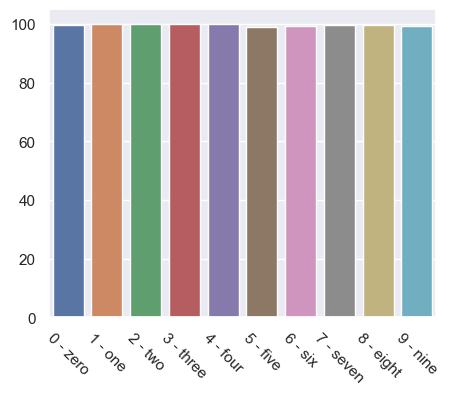

In [30]:
#resNet mnist
allLabels, allPrediction, testAccuracies = test_model(resNet_mnist, classesNumericMnist, dataloaders_mnist['test'])
show_test_results(allLabels, allPrediction, testAccuracies, classesMnist, False, True)

Inference Time: 35.5569 s Throughput: 281.2396 fps
Testing Overall Accuracy: 95.550000 


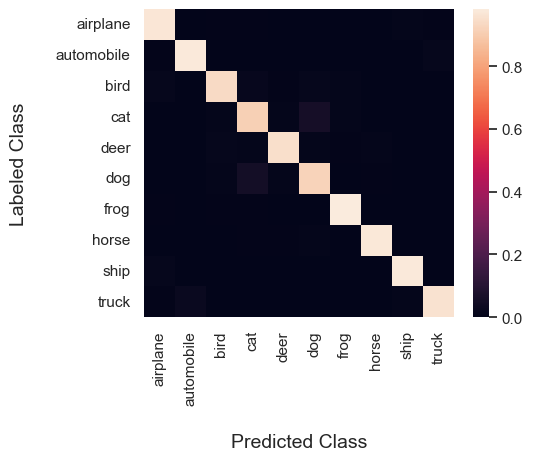

In [31]:
#resNet cifar
allLabels, allPrediction, testAccuracies = test_model(resNet_cifar, classesNumericCifar, dataloaders_cifar['test'])
show_test_results(allLabels, allPrediction, testAccuracies, classesCifar, True, False)

### 4.3 Test Inception Models

In [32]:
#Inception mnist
allLabels, allPrediction, testAccuracies = test_model(inception_mnist, classesNumericMnist, inception_dataloaders_mnist['test'])
show_test_results(allLabels, allPrediction, testAccuracies, classesMnist, False, False)

Inference Time: 86.9028 s Throughput: 115.0711 fps
Testing Overall Accuracy: 99.710000 


In [33]:
#Inception cifar
allLabels, allPrediction, testAccuracies = test_model(inception_cifar, classesNumericCifar, inception_dataloaders_cifar['test'])
show_test_results(allLabels, allPrediction, testAccuracies, classesCifar, False, False)

Inference Time: 73.4866 s Throughput: 136.0791 fps
Testing Overall Accuracy: 95.710000 


## 5. Post Training Static Quantize Models

In [34]:
#inspired by https://pytorch.org/tutorials/advanced/static_quantization_tutorial.html
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

In [35]:
#Load first 100 training data images, with batch of one
sampleMnist = torch.utils.data.DataLoader(torch.utils.data.Subset(mnist[0], list(range(0,100))),batch_size=1)
sampleCifar = torch.utils.data.DataLoader(torch.utils.data.Subset(cifar[0], list(range(0,100))),batch_size=1)

#inspired by https://pytorch.org/docs/master/quantization.html#prototype-fx-graph-mode-quantization
#GraphFx Quantization is realtivly new functionality that configures layers automatically to accept quantization
#Post training static quantization
def pt_quantize_and_compare(model_temp, sample_data_loader, noisy=True, qconfig_mapping=False):
    model_to_quantize_2 = copy.deepcopy(model_temp)
    model_to_quantize_2.to('cpu')
    model_to_quantize_2.eval()
    
    #currently using Graph FX quant, if we need to switch see this other source
    #https://pytorch.org/blog/quantization-in-practice/#quantization-aware-training-qat
    

    #Prepare qconfig if one not provided
    if not qconfig_mapping:
        qconfig_mapping = torch.ao.quantization.get_default_qconfig_mapping("qnnpack")
    
    # Alternative Method:
    # Significantly less size reduction, better performance kept
    # post training dynamic/weight_only quantization
    #qconfig_mapping = torch.ao.quantization.QConfigMapping().set_global(torch.ao.quantization.default_dynamic_qconfig)
    
    #Prepare
    model_prepared_2 = torch.ao.quantization.quantize_fx.prepare_fx(model_to_quantize_2, qconfig_mapping, next(iter(sample_data_loader)))
    
    #Calibrate 
    with torch.inference_mode():
        for sample_data, sample_label in iter(sample_data_loader):
            model_prepared_2(sample_data)
    
    #Quantize
    model_quantized =  torch.ao.quantization.quantize_fx.convert_fx(model_prepared_2)
    
    if noisy:
        print("Before:")
        print_size_of_model(model_temp)
        print("After:")
        print_size_of_model(model_quantized)
        
    return model_quantized

In [36]:
mobilenet_mnist_quantized = pt_quantize_and_compare(mobilenet_mnist, sampleMnist) 
mobilenet_cifar_quantized = pt_quantize_and_compare(mobilenet_cifar, sampleCifar, False)

Before:
Size (MB): 9.173401
After:
Size (MB): 2.341033
Before:
Size (MB): 9.173401
After:
Size (MB): 2.341033


In [37]:
resNet_mnist_quantized = pt_quantize_and_compare(resNet_mnist, sampleMnist)
resNet_cifar_quantized = pt_quantize_and_compare(resNet_cifar, sampleCifar, False)

Before:
Size (MB): 94.413179
After:
Size (MB): 23.651737


In [38]:
inception_mnist_quantized = pt_quantize_and_compare(inception_mnist, sampleMnist) 
inception_cifar_quantized = pt_quantize_and_compare(inception_cifar, sampleCifar, False)

Before:
Size (MB): 97.798375
After:
Size (MB): 21.957233


# 6. Investigate Quantized Model Performance

In [39]:
def compare_models(base_mnist, base_cifar, new_mnist, new_cifar, model_name, test_device=DEVICE, mnist=True, cifar=True, is_inception=False):
    if is_inception:
        dataloaders_mnist_temp = inception_dataloaders_mnist['test']
        dataloaders_cifar_temp = inception_dataloaders_cifar['test']
    else:
        dataloaders_mnist_temp = dataloaders_mnist['test']
        dataloaders_cifar_temp = dataloaders_cifar['test']
    if mnist:
        print(model_name,"MNIST Base Model:")
        _ = test_model(base_mnist, classesNumericMnist, dataloaders_mnist_temp, test_device) 
        print(model_name, "MNIST Quantized Model:")
        _ = test_model(new_mnist, classesNumericMnist, dataloaders_mnist_temp, test_device)    
        
    if cifar:
        if mnist:
            print()
        print(model_name, "CIFAR Base Model:")
        _ = test_model(base_cifar, classesNumericCifar, dataloaders_cifar_temp, test_device) 
        print(model_name, "CIFAR Quantized Model:")
        _ = test_model(new_cifar, classesNumericCifar, dataloaders_cifar_temp, test_device)

In [41]:
#Note, quantized models testing must be on CPU
compare_models(mobilenet_mnist, mobilenet_cifar, mobilenet_mnist_quantized, mobilenet_cifar_quantized, 'MobileNet', 'cpu', True, False)

MobileNet MNIST Base Model:
Inference Time: 269.3227 s Throughput: 37.1302 fps
Testing Overall Accuracy: 99.620000 
MobileNet MNIST Quantized Model:
Inference Time: 89.7954 s Throughput: 111.3643 fps
Testing Overall Accuracy: 75.750000 


In [43]:
#compare_models(resNet_mnist, resNet_cifar, resNet_mnist_quantized, resNet_cifar_quantized, 'ResNet', 'cpu')

In [44]:
#compare_models(inception_mnist, inception_cifar, inception_mnist_quantized, inception_cifar_quantized, 'Inception', 'cpu',is_inception=True)

# 7. Test Post Quantization Improvement - Paul Todo

We see that mobilenetV2 suffers from accuracy loss after quantization. How can we improve accuracy after quantization? One strategy we can use is analyzing the SQNR of each layer in the network, to understand where the most quantization loss occurs. With this knowledge, we can modify the qconfig_dict settings to skip the problem layers during quantization. 

C:\Users\Philip\AppData\Local\Temp\ipykernel_8416\3139979702.py:36: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


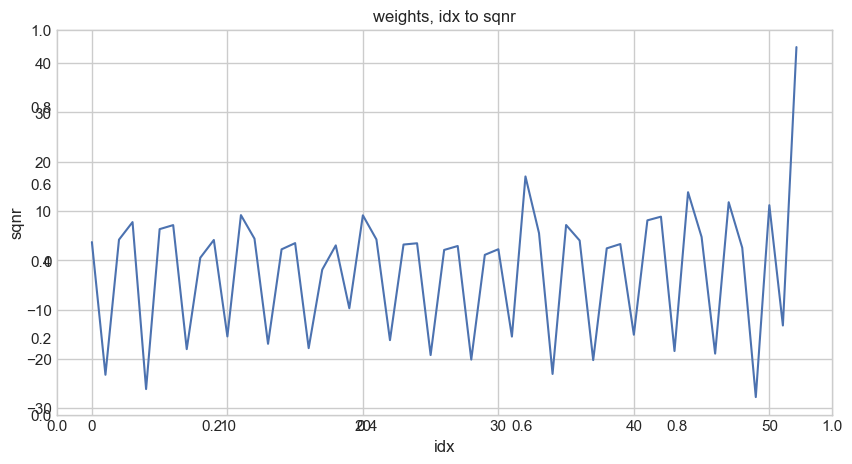

In [42]:
# Compare weights of float_model and qmodel.
# Note: when comparing weights in models with Conv-BN for PTQ, we need to compare
# weights after Conv-BN fusion for a proper comparison.  Because of this, we use
# `prepared_model` instead of `float_model` when comparing weights.
# Extract conv and linear weights from corresponding parts of two models, and save
# them in `wt_compare_dict`.
mobilenet_wt_compare_dict = ns.extract_weights(
   'fp32',  # string name for model A
   mobilenet_mnist,  # model A
   'int8',  # string name for model B
   mobilenet_mnist_quantized,  # model B
)
# calculate SQNR between each pair of weights
# SQNR is a measure of quantization loss, large SQNR value means the quantization loss is small
ns.extend_logger_results_with_comparison(
   mobilenet_wt_compare_dict,  # results object to modify inplace
   'fp32',  # string name of model A (from previous step)
   'int8',  # string name of model B (from previous step)
   torch.ao.ns.fx.utils.compute_sqnr,  # the function to use to compare two tensors
   'sqnr',  # the name to use to store the results under
)
# massage the data into a format easy to graph and print
# Note: no util function for this since use cases may be different per user
# Note: there is a lot of debugging data, and it will be challenging to print all of it
# and fit on a laptop screen.  It is up to the user to decide which data is useful for them.
mobilenet_wt_to_print = []
for idx, (layer_name, v) in enumerate(mobilenet_wt_compare_dict.items()):
    mobilenet_wt_to_print.append([
        idx,
        layer_name,                                                   
        v['weight']['int8'][0]['prev_node_target_type'],                      
        v['weight']['int8'][0]['values'][0].shape,
        v['weight']['int8'][0]['sqnr'][0],
    ])
    
plt.style.use('seaborn-whitegrid')
# a simple line graph
def plot(xdata, ydata, xlabel, ylabel, title):
    fig = plt.figure(figsize=(10, 5), dpi=100)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    ax = plt.axes()
    ax.plot(xdata, ydata)     
# plot the SQNR between fp32 and int8 weights for each layer
# Note: we may explore easier to read charts (bar chart, etc) at a later time, for now
# line chart + table is good enough.
plot([x[0] for x in mobilenet_wt_to_print], [x[4] for x in mobilenet_wt_to_print], 'idx', 'sqnr', 'weights, idx to sqnr')

# ***************************************************************************** For Paul
# *****************************************************************************

# To quantize specific layers, create a qconfig_dict like: https://pytorch.org/blog/quantization-in-practice/#sensitivity-analysis and pass to the function pt_quantize_and_compare()

# 8. Philip TODO: Investigate other quantized model options: Dropout, Quantize aware training, dynamic quantization

## 8.1 Post Quantization - Quantize Aware Training